In [12]:
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import integral_intensity_projection, vertical_line_drawing, get_rotation_angle
from utils.edge import gum_jaw_separation, get_slope, window_avg, get_valley_window
from scipy.signal import find_peaks
from dotenv import load_dotenv

from glob import glob
from pathlib import Path

matplotlib.use('module://matplotlib_inline.backend_inline')
load_dotenv()



True

In [4]:
data_dir = '..' / Path(os.getenv('DATASET_DIR'))


YOLOv5  torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 270 layers, 7041205 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


requirements: C:\Users\denni\anaconda3\envs\dentist-cv\Lib\site-packages\yolov5\requirements.txt not found, check failed.


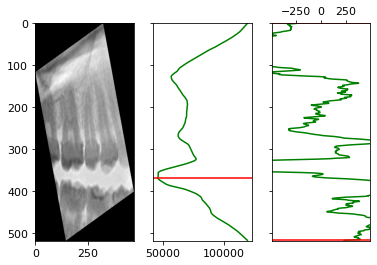

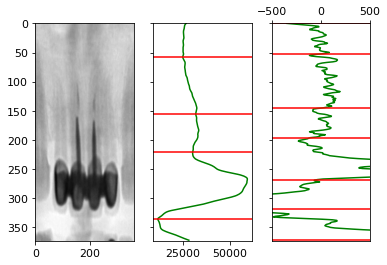

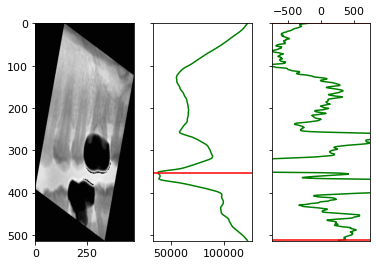

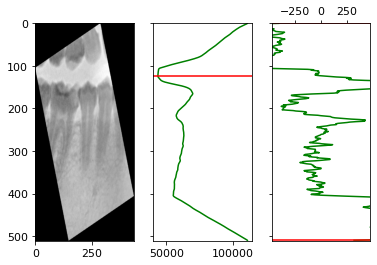

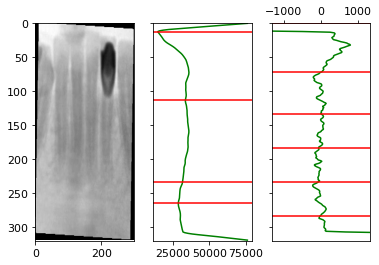

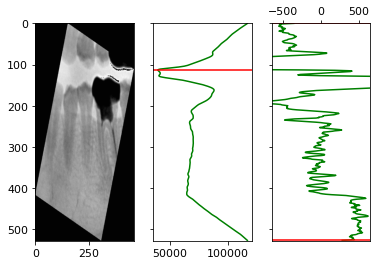

In [20]:
image_names = list(data_dir.glob('*00008026.jpg'))
image_number = 1

for i in range(len(image_names[:image_number])):
    filepath_image = image_names[i]
    filename = filepath_image.stem

    model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
    # Image
    # Inference
    results = model(filepath_image)

    teeth_roi = get_teeth_ROI(results)
    teeth_roi_images = teeth_roi['images'][filename]
    teeth_roi_split_teeth = teeth_roi['split_teeth']

    for teeth_roi_image in teeth_roi_images:
        flag = teeth_roi_image['flag']
        image = cv.cvtColor(teeth_roi_image['image'], cv.COLOR_RGB2GRAY)

        theta, hor = get_rotation_angle(image, flag=flag)
        image = ndimage.rotate(image, theta, reshape=True, cval=255)

        height, width = image.shape
        index = np.array(range(height))

        hor, _ = integral_intensity_projection(image)
        hor = window_avg(hor)
        hor_slope = get_slope(hor)
        window_positions, _, hor_valleys = get_valley_window(hor_slope, hor, window_size_0=50, left_margin_0=30)

        # gum_sep_line, jaw_sep_line, theta, hor_valleys, hor = gum_jaw_separation(source, flag=flag)

        fig, axs = plt.subplots(1, 3, sharey='all')
        # row i col 0
        # image = vertical_line_drawing(image, *window_position, color=0)
        axs[0].imshow(1 - image, aspect='auto', cmap='gray')
        # for v in valleys:
        #     axs[i][1].axhline(y=v, color='r')

        # row i col 1
        axs[1].plot(hor, index, 'g')
        # axs[i][1].xaxis.tick_top()
        axs[1].set_ylim(height, 0)
        for v in hor_valleys:
            axs[1].axhline(y=v, color='r')

        # row i col 2
        axs[2].plot(hor_slope, index, 'g')
        axs[2].xaxis.tick_top()
        axs[2].set_ylim(height, 0)
        axs[2].set_xlim(-hor_slope.std(), hor_slope.std())
        for v in window_positions:
            axs[2].axhline(y=v, color='r')

        plt.show()



[113]
[214 227 241 277 279 280 281 295 304 317 321 348 366 382 404 413]
[       -293]


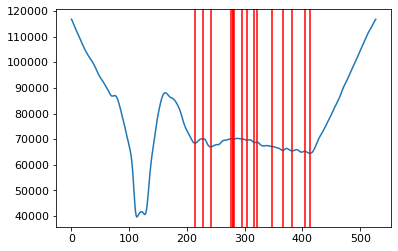

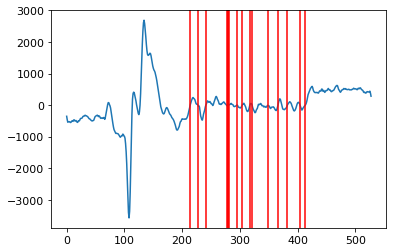

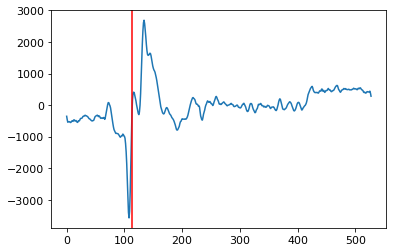

In [22]:
x = np.array(range(0, hor.shape[0]))

dy = np.gradient(hor)
dx = np.gradient(x)
d = np.gradient(hor, x)

# a = d[hor_valleys]

zero_points = np.where(abs(d) < 10)[0]

print(hor_valleys)
print(zero_points)

plt.plot(hor)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(d)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(hor_slope)
for i in hor_valleys:
    plt.axvline(x=i, color='r')
plt.show()
